In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision as tv
import albumentations as A
from torch.utils.data.sampler import WeightedRandomSampler
from PIL import Image

import cv2

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Augmentation

In [ ]:
# scale_size = 200
scale_size = 224

In [ ]:
transforms = tv.transforms.Compose([
    tv.transforms.Resize((int(scale_size * 1.2), int(scale_size * 1.2))),
    tv.transforms.RandomCrop(scale_size),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.RandomRotation(25),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.classes = self.annotations['label'].unique()
        self.encode = {k: v for v, k in enumerate(self.classes)}
        self.decode = {v: k for k, v in self.encode.items()}
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.encode[self.annotations.iloc[idx, 1]]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
csv_file = '/kaggle/input/nn-image/train_labels.csv'
root_dir = '/kaggle/input/nn-image/train_test_data/train'

In [ ]:
dataset_img = ImageDataset(csv_file=csv_file, root_dir=root_dir, transform=transforms)

In [ ]:
def show_image(image_tensor):
    # Переводим тензор обратно в изображение
    image = image_tensor.numpy().transpose((1, 2, 0))
    # Нормализуем изображение
    image = image * 255
    image = image.astype('uint8')

    plt.imshow(image)
    plt.axis('off')
    plt.show()

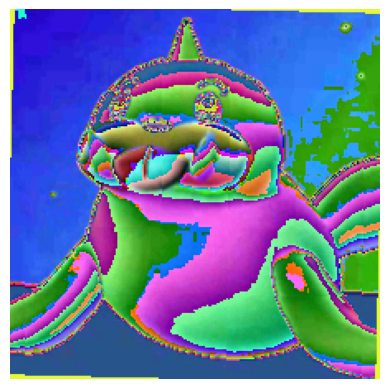

20


In [ ]:
idx = 20
show_image(dataset_img[idx][0])
print(dataset_img[idx][1])

In [ ]:
classes_name = np.array(dataset_img.classes)
classes_name

array(['Koffing', 'Venonat', 'Nidoking', 'Victreebel', 'Persian', 'Ekans',
       'Jigglypuff', 'Vulpix', 'Lickitung', 'Cloyster', 'Paras',
       'Pidgeotto', 'Rapidash', 'Ditto', 'Clefairy', 'Charmander',
       'Kakuna', 'Flareon', 'Charmeleon', 'Raichu', 'Seel', 'Omanyte',
       'Machamp', 'Tauros', 'Primeape', 'Ponyta', 'Hitmonchan', 'Mankey',
       'Electabuzz', 'Chansey', 'Hypno', 'Gloom', 'Nidoqueen', 'Vaporeon',
       'Rattata', 'Metapod', 'Sandshrew', 'Kabuto', 'Eevee', 'Pinsir',
       'Arbok', 'Kabutops', 'Seadra', 'Lapras', 'Arcanine', 'Poliwhirl',
       'Gyarados', 'Jynx', 'Venusaur', 'Venomoth', 'Kadabra',
       'Butterfree', 'Seaking', 'Tangela', 'Slowpoke', 'Growlithe',
       'Marowak', 'Spearow', 'Electrode', 'Drowzee', 'Dewgong',
       'Squirtle', 'Magnemite', 'Exeggcute', 'Bulbasaur', 'Golbat',
       'Weezing', 'Muk', 'MrMime', 'Porygon', 'Magmar', 'Sandslash',
       'Raticate', 'Vileplume', 'Wigglytuff', 'Starmie', 'Wartortle',
       'Gastly', 'Voltorb', 

In [ ]:
len(classes_name)

151

In [ ]:
train_idx, valid_idx = train_test_split(list(range(len(dataset_img))), train_size=0.8)
dataset = {
    'train': torch.utils.data.Subset(dataset_img, train_idx),
    'valid': torch.utils.data.Subset(dataset_img, valid_idx)
}

dataset_size = {ds: len(dataset[ds]) for ds in ['train', 'valid']}

# dataloader_full_data = torch.utils.data.DataLoader(
#         dataset=dataset, batch_size=8, shuffle=True, num_workers=2
# )

dataloader = {
    'train': torch.utils.data.DataLoader(
        dataset=dataset['train'], batch_size=8, shuffle=True, num_workers=2
    ),
    'valid': torch.utils.data.DataLoader(
        dataset=dataset['valid'], batch_size=8, shuffle=False, num_workers=2
    ),
}

# Prapare for submit

In [ ]:
transform = tv.transforms.Compose([
    tv.transforms.Resize((int(scale_size), int(scale_size))),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])
root_dir_test = '/kaggle/input/nn-image/train_test_data/test'
csv_file_test = '/kaggle/input/nn-image/sample_submission.csv'
dataset_test = ImageDataset(csv_file=csv_file_test, root_dir=root_dir_test, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=24)

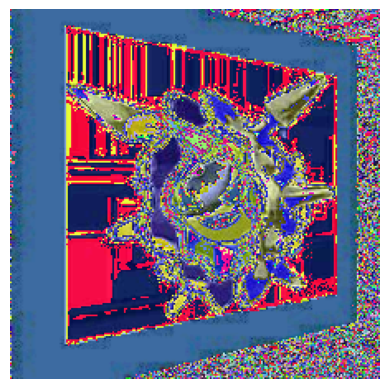

0


In [ ]:
idx = 5
show_image(dataset_test[idx][0])
print(dataset_test[idx][1])

In [ ]:
def predict(model, dataloader_test):
    logits = []
    model.eval()
    with torch.no_grad():
        for inputs, _ in tqdm(dataloader_test):
            inputs = inputs.to(device)
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
def predict_to_submission(model, dataloader_test=dataloader_test, dataset_classes=classes_name):
    probs = predict(model, dataloader_test)
    print(probs.shape)
    predictions = np.argmax(probs, axis=1)
    preds = classes_name[predictions]
    submission = pd.read_csv('/kaggle/input/nn-image/sample_submission.csv')
    submission['label'] = preds
    submission.to_csv('./submission.csv', index=False)

# Modeling

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
def train_model(
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.nn.Module,
    sheduler: torch.nn.Module,
    epochs: int = 7
) -> (torch.nn.Module, dict):
    r"""Training the model. Returns best model, dictionary of train and validation losses, dictionary of train and validation accuracies.
    Args:
        model (torch.nn.Module): Neural network
        criterion (torch.nn.Module): Cost function
        optimizer (torch.nn.Module): Optimization algorithm
        sheduler (torch.nn.Module): Learning rate change policy
        epochs (int): Number of training iterations. Default: 7
    """

    losses = {'train': [], 'valid': []}
    accuracies = {'train': [], 'valid': []}
    best_model_weights = model.state_dict()
    best_accuracy = 0.
    progress = tqdm(range(epochs), desc='Epoch:')

    for epoch in progress:
        for phase in ['train', 'valid']:
            loss_accum = 0.
            corr_accum = 0
            model.train(mode=(phase == 'train'))

            for inputs, labels in tqdm(dataloader[phase], desc=f'Phase {phase}:'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                if phase == 'train':
                    optimizer.zero_grad()
                    outp = model(inputs)
                    loss = criterion(outp, labels)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outp = model(inputs)
                        loss = criterion(outp, labels)

                preds = torch.argmax(outp, -1)
                loss_accum += loss.item()
                corr_accum += (preds == labels.data).sum()

            if phase == 'train':
                sheduler.step()

            epoch_loss = loss_accum / dataset_size[phase]
            epoch_accuracy = corr_accum / dataset_size[phase]
            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_accuracy)
            progress.set_description('loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_accuracy))
            if phase == 'valid' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_weights = model.state_dict()

    model.load_state_dict(best_model_weights)
    return model, losses, accuracies

In [ ]:
def show_metrics(metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics['train'], label='train')
    plt.plot(metrics['valid'], label='val')
    plt.grid()
    plt.legend()
    plt.show()

In [ ]:
def show_metrics_all(losses, accuracies):
    def show_ax(ax_idx, metric, title):

        axes[ax_idx].plot(metric['train'], label='train')
        axes[ax_idx].plot(metric['valid'], label='valid')
        axes[ax_idx].grid()
        axes[ax_idx].legend()
        axes[ax_idx].set_title(title)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    show_ax(0, losses, 'loss')
    show_ax(1, accuracies, 'accuracy')
    plt.show()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

## My ResNet

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
my_resnet = ResNet(ResidualBlock, [6, 8, 6, 8], num_classes = 151)
print(count_parameters(my_resnet))

46384023


In [ ]:
my_resnet.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_resnet.parameters(), lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
my_resnet, losses, accuracies = train_model(my_resnet, loss, optimizer, sheduler, epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

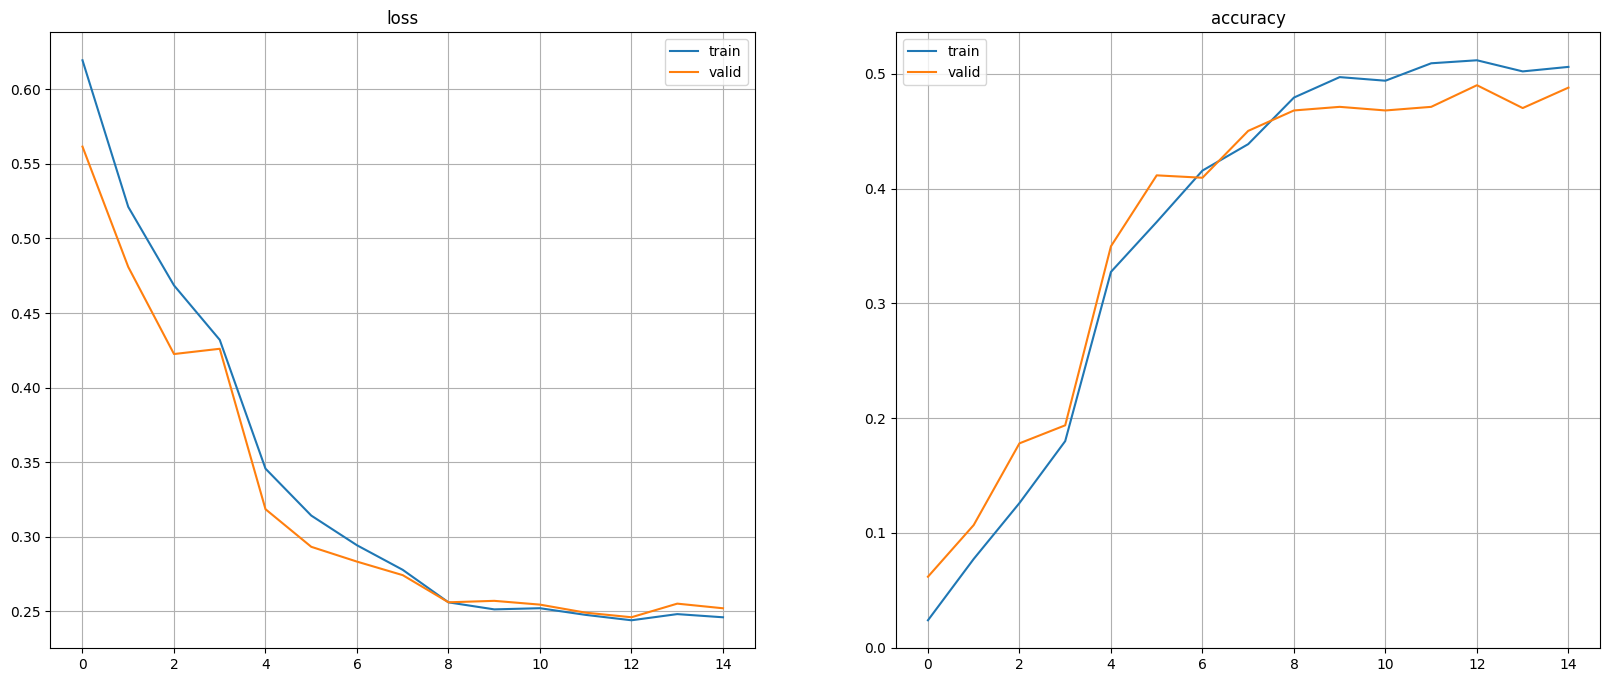

In [ ]:
accuracies['train'] = list([acc.cpu() for  acc in accuracies['train']])
accuracies['valid'] = list([acc.cpu() for  acc in accuracies['valid']])
show_metrics_all(losses, accuracies)

In [ ]:
predict_to_submission(my_resnet)

  0%|          | 0/86 [00:00<?, ?it/s]

(2046, 151)


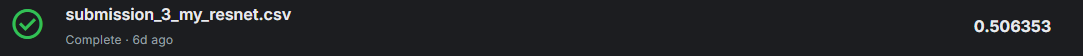

## Pretrain ResNet

In [ ]:
model_resnet_pretrain = tv.models.resnet152(pretrained=True)

for param in model_resnet_pretrain.parameters():
    param.require_grad = False

num_features = model_resnet_pretrain.fc.in_features
model_resnet_pretrain.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 2048),
            nn.ReLU(),
            nn.Linear(2048, len(classes_name))
)

model_resnet_pretrain.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=2048, bias=True)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=151, bias=True)
)

In [ ]:
model_resnet_pretrain.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model_resnet_pretrain.parameters()), lr=1e-4)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

model_resnet_pretrain, losses, accuracies = train_model(model_resnet_pretrain, loss, optimizer, sheduler, epochs=15)

Epoch::   0%|          | 0/15 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

Phase train::   0%|          | 0/478 [00:00<?, ?it/s]

Phase valid::   0%|          | 0/120 [00:00<?, ?it/s]

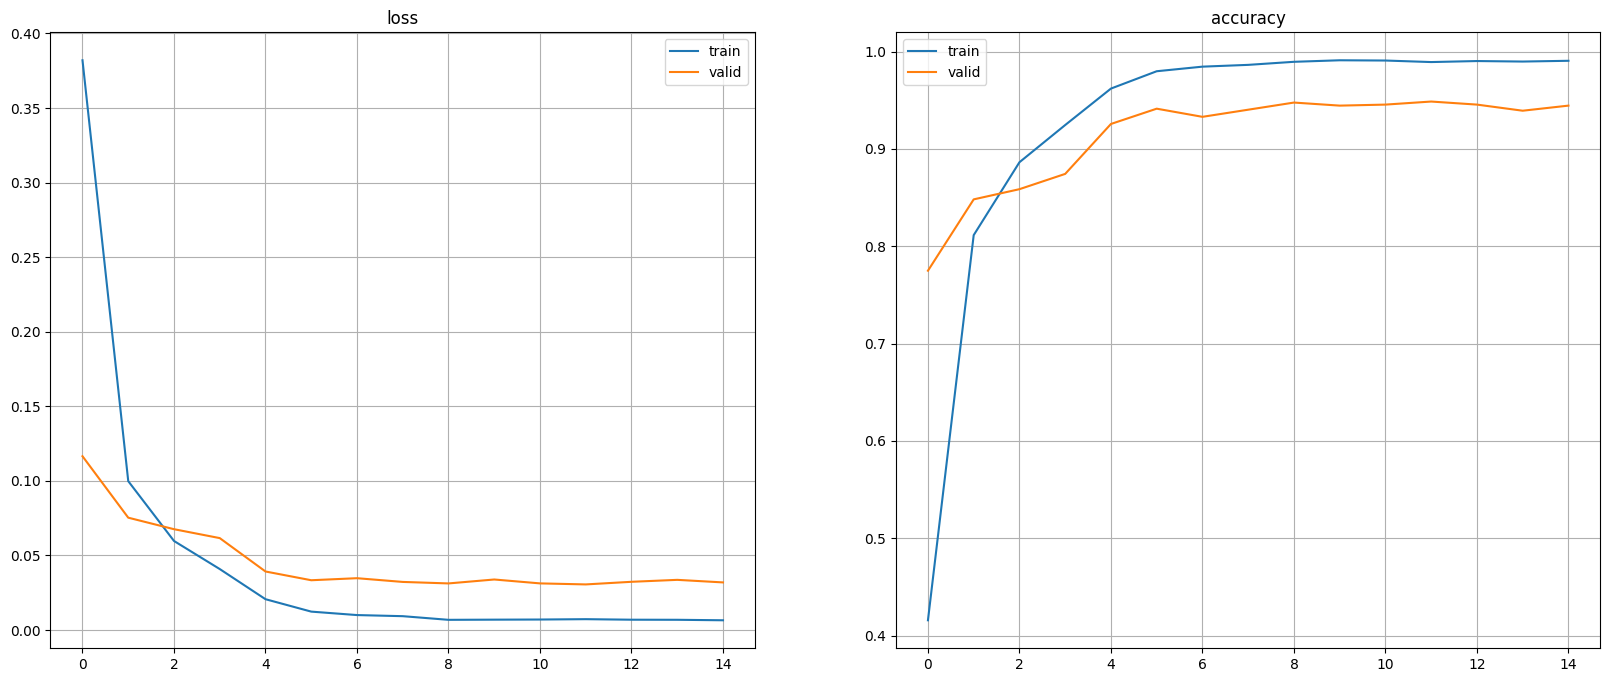

In [ ]:
accuracies['train'] = list([acc.cpu() for  acc in accuracies['train']])
accuracies['valid'] = list([acc.cpu() for  acc in accuracies['valid']])
show_metrics_all(losses, accuracies)

In [ ]:
predict_to_submission(model_resnet_pretrain)

  0%|          | 0/86 [00:00<?, ?it/s]

(2046, 1000)


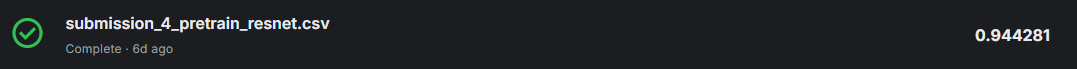